# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

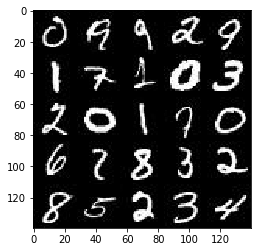

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

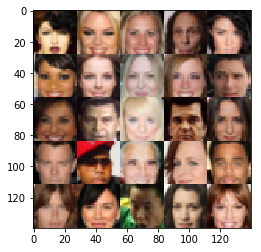

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels])
    input_z =  tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='z_dim')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        dropout1 = tf.nn.dropout(relu1, keep_prob=0.88)
        # 14x14x32 now

        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, trainable=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, keep_prob=0.88)
        # 7x7x128 now

        # Flatten it
        flat = tf.reshape(dropout2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)     

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(images=logits, size=(28,28))
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Smoothing
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                labels = tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, 
                                                                    labels = tf.ones_like(d_model_fake)))    
    
    return (d_loss, g_loss)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts 
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # !!! important 用法参阅blog链接在下面
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  
    with tf.control_dependencies(update_ops):  
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


####  参阅 blog
- [TensorFlow batch normalization](https://blog.csdn.net/zywvvd/article/details/73557928)
- [tf.control_dependencies()作用及用法](https://blog.csdn.net/PKU_Jade/article/details/73498753)
- [tensorflow学习笔记（四十一）：control dependencies](https://blog.csdn.net/u012436149/article/details/72084744)

## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learning_rate_ = model_inputs(image_height=data_shape[1],
                                                      image_width=data_shape[2],
                                                      image_channels=data_shape[3],
                                                      z_dim = z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    index = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     learning_rate_: learning_rate})
                index = index + 1
                
                if index % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.7074


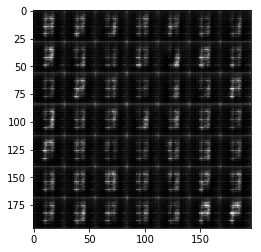

Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.7581


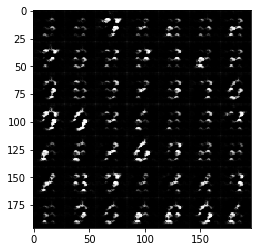

Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.7326


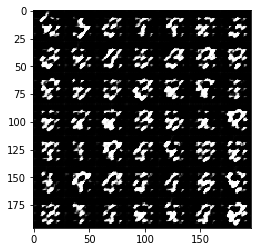

Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.8077


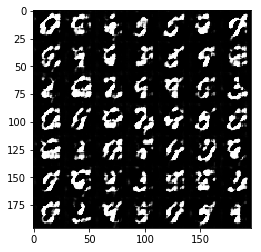

Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.7379


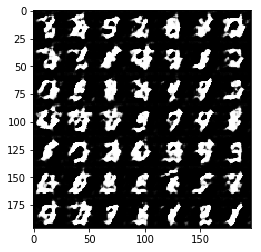

Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.8063


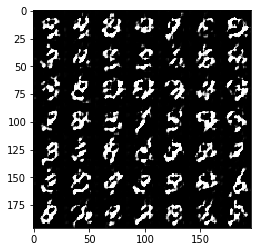

Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.8623


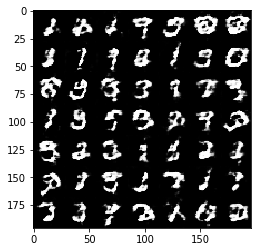

Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.8964


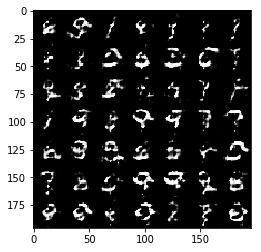

Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.7828


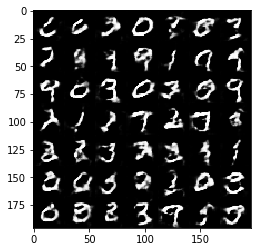

Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.7951


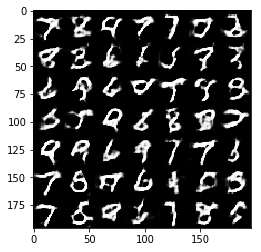

Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.7084


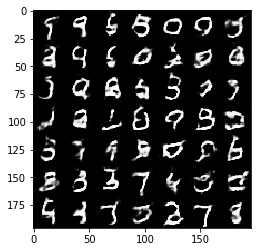

Epoch 2/2... Discriminator Loss: 1.3809... Generator Loss: 0.7692


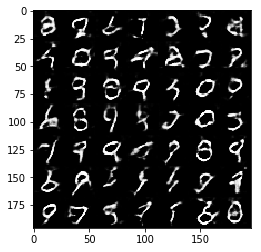

Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.8073


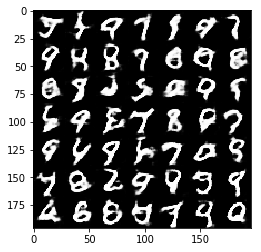

Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.7798


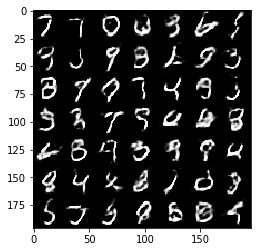

Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.8107


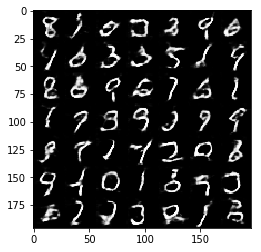

Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.8186


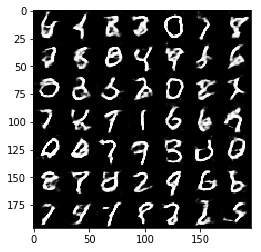

Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.8603


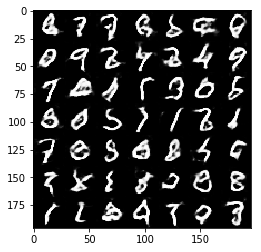

Epoch 2/2... Discriminator Loss: 1.4548... Generator Loss: 0.9154


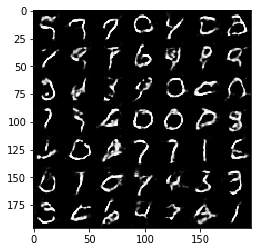

Epoch 2/2... Discriminator Loss: 1.3444... Generator Loss: 0.8748


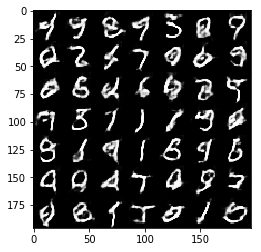

Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.8513


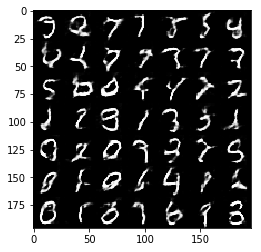

In [ ]:
batch_size = 60
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.8871


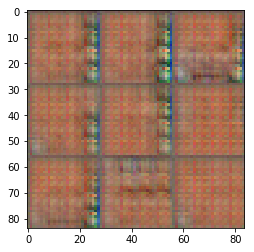

Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9908


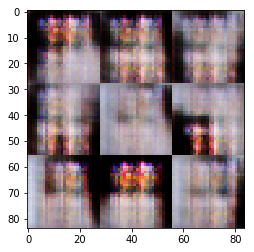

Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7038


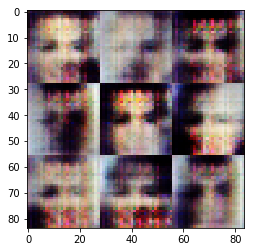

Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7466


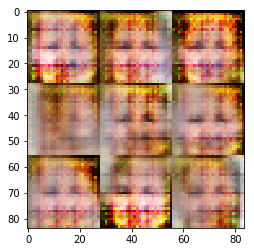

Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.9175


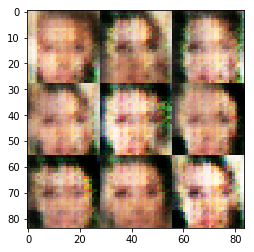

Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 0.8802


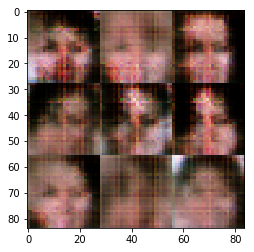

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7394


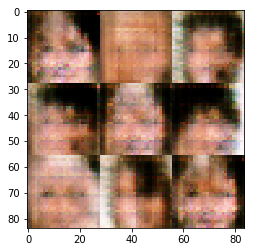

Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.7593


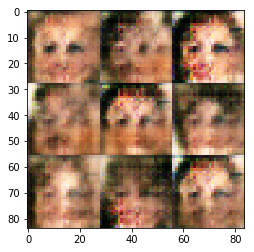

Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.8833


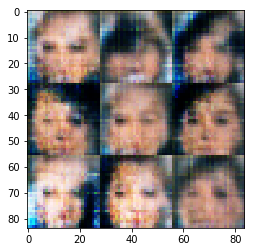

Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6439


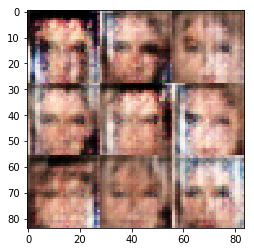

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6640


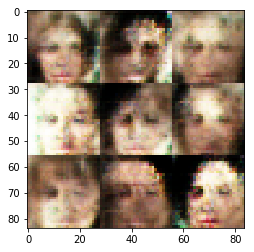

Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.5841


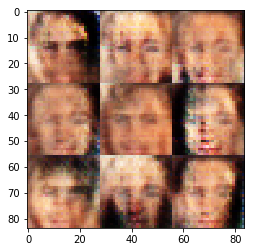

Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.8238


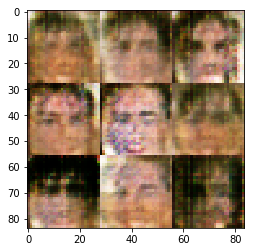

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8260


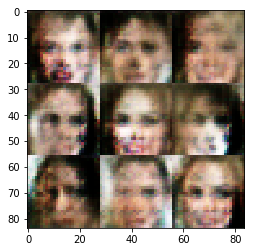

Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.9763


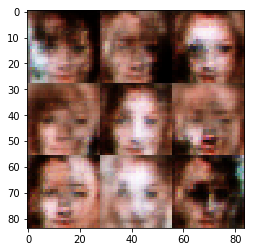

Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8865


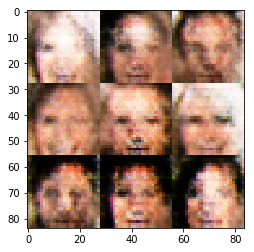

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7252


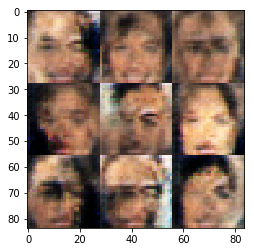

Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.4299


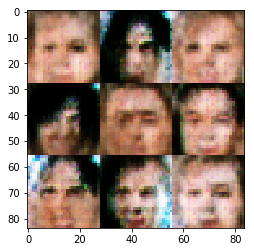

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.8721


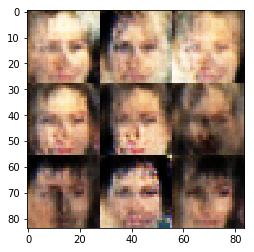

Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5498


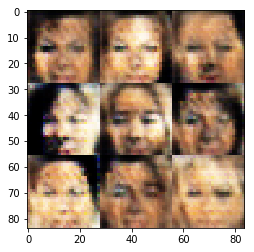

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8215


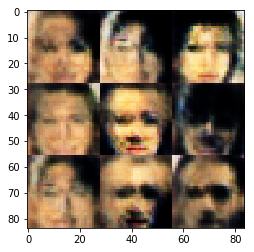

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8690


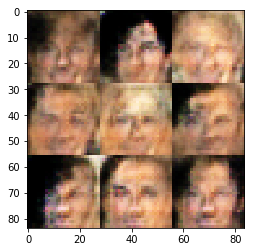

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6694


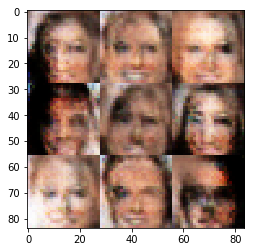

Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.5599


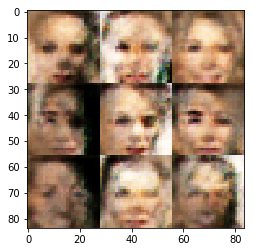

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7724


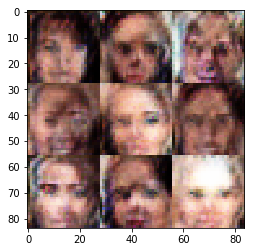

Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8008


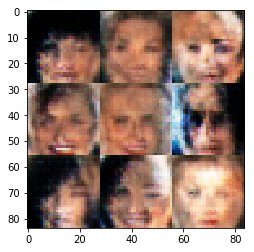

Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7213


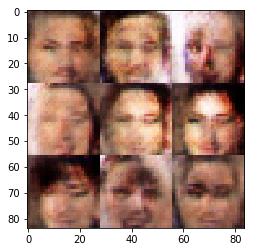

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9418


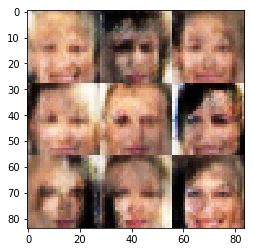

Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8173


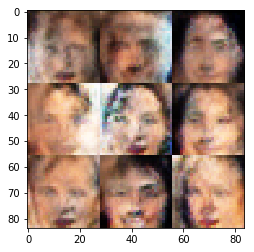

Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.7890


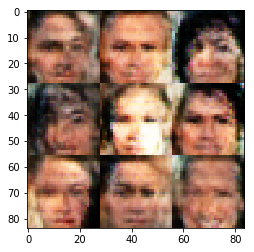

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6712


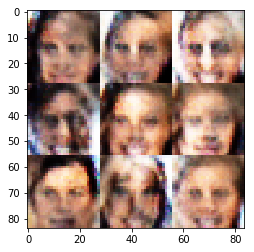

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7112


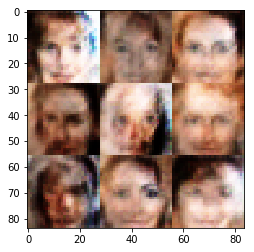

Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7170


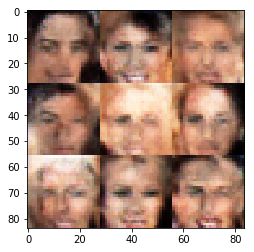

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.9833


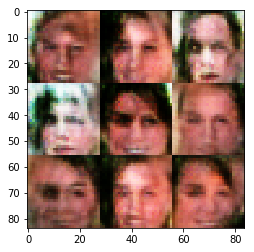

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8588


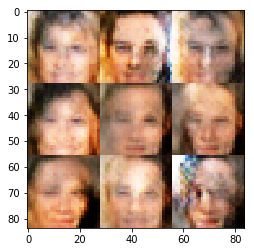

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6654


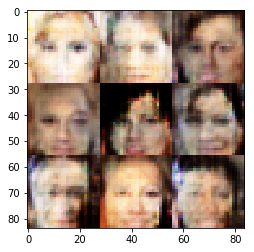

Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8536


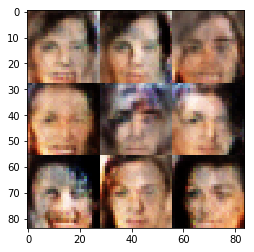

Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8512


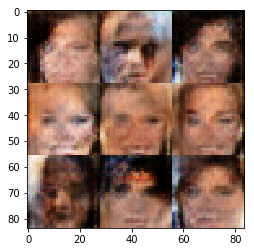

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8171


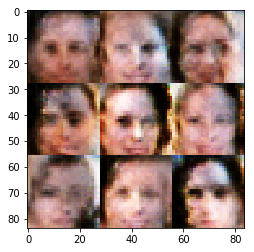

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7763


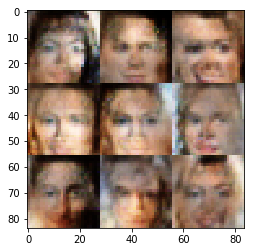

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.9031


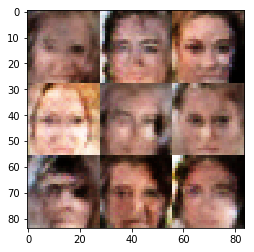

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8614


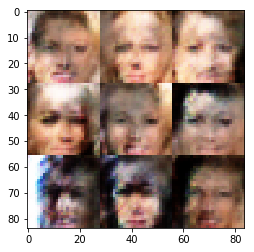

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8808


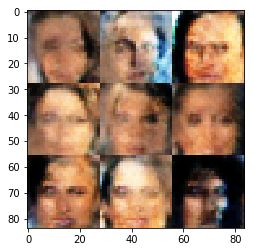

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.9348


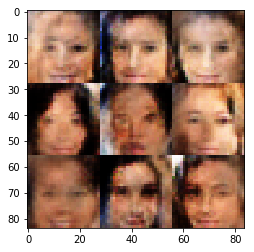

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.9599


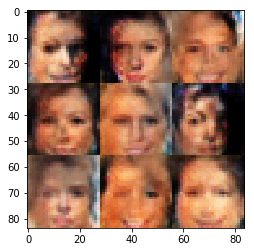

Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7094


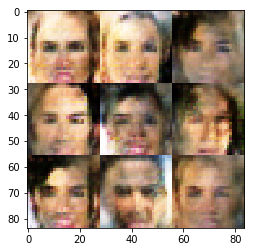

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7879


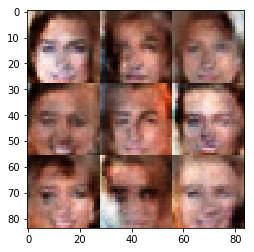

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.9199


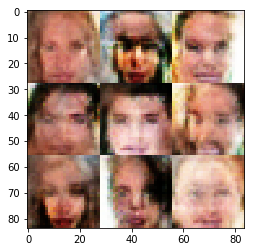

Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.6447


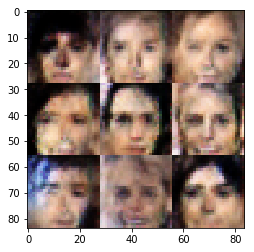

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7768


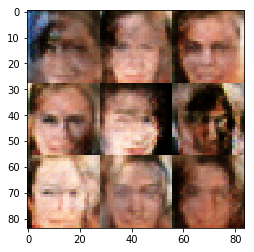

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8267


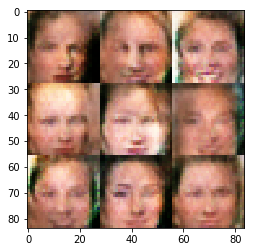

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7454


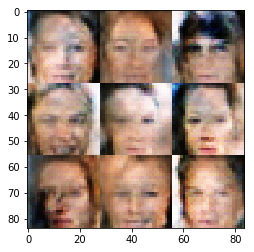

Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7707


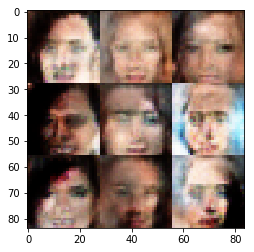

Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7546


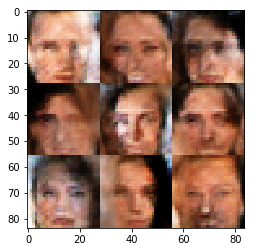

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8068


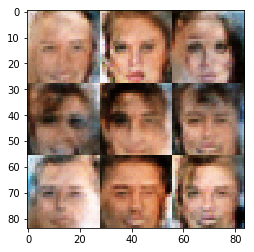

Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7856


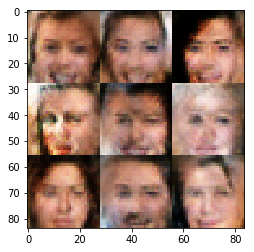

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.7514


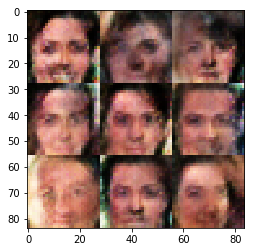

Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7900


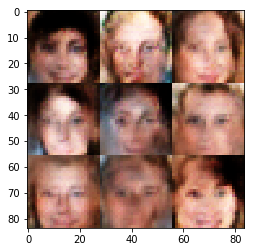

Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7281


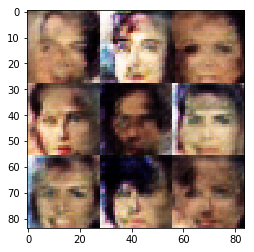

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8116


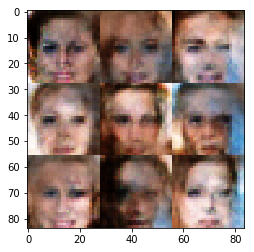

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7292


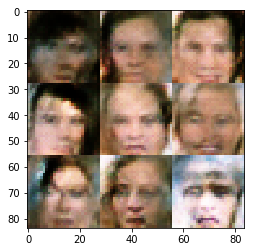

Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.7362


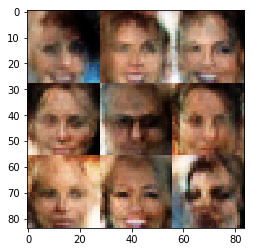

Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8725


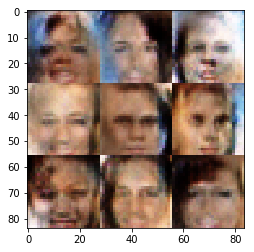

Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.7931


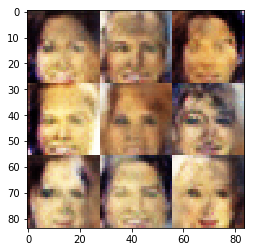

Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7560


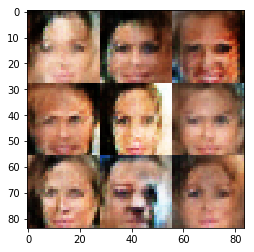

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8182


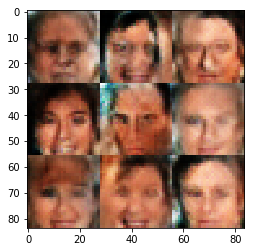

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 1.0392


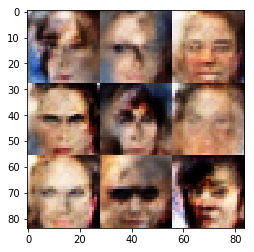

Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7606


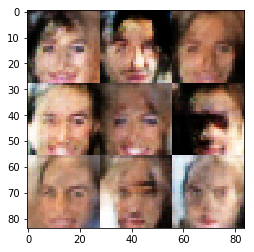

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7339


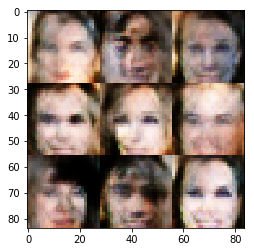

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8318


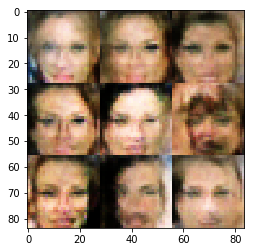

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6620


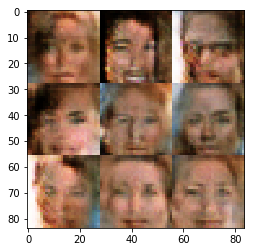

Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8831


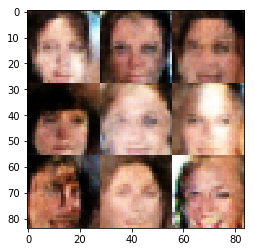

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7296


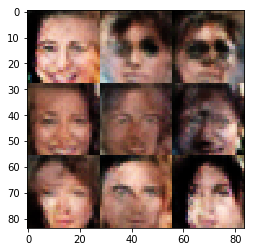

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7470


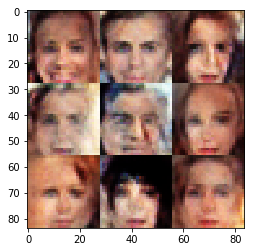

Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8048


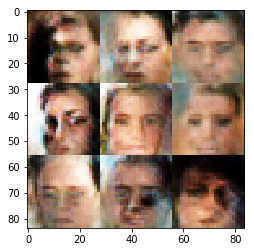

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9534


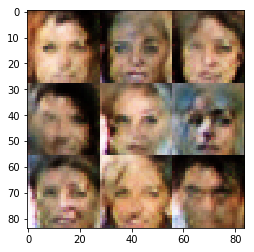

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8073


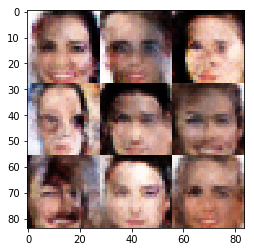

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7905


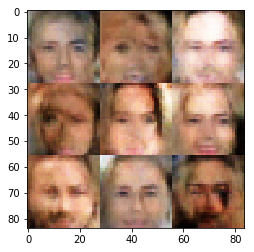

Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.8085


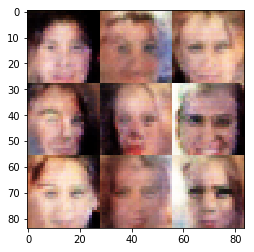

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8352


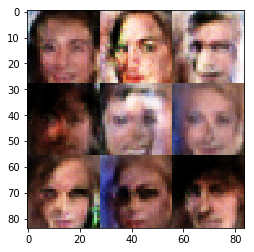

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.8378


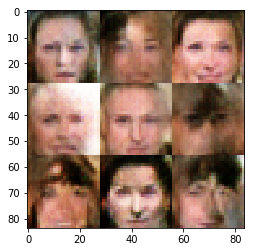

Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7661


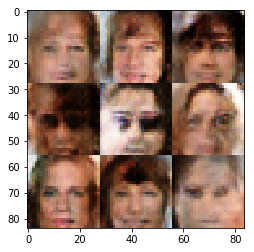

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8223


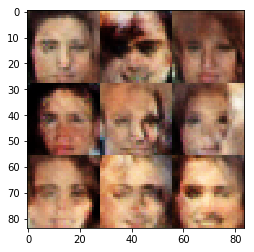

Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7316


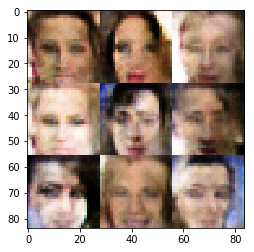

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.9088


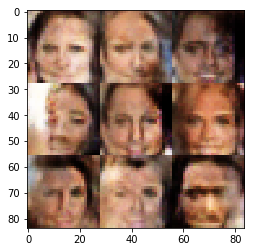

Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8129


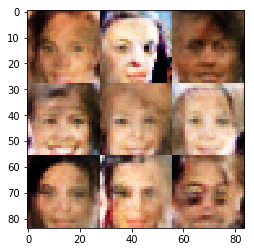

Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9850


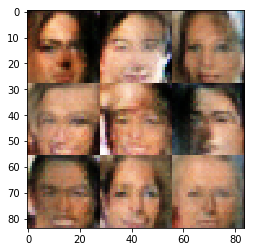

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8268


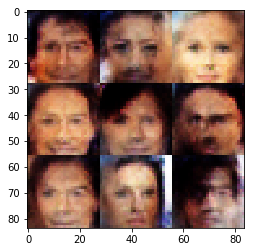

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6847


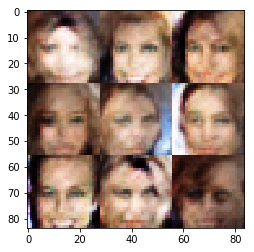

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8602


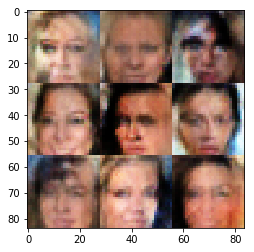

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8217


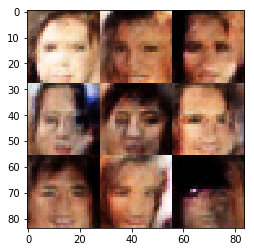

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8229


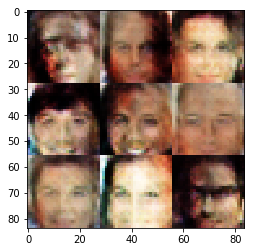

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8485


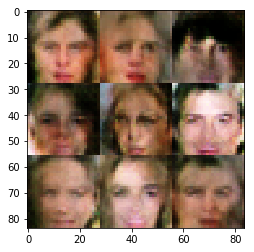

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8231


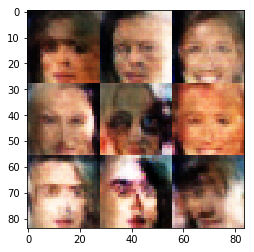

Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.8252


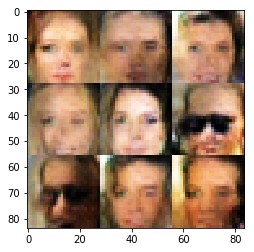

Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9535


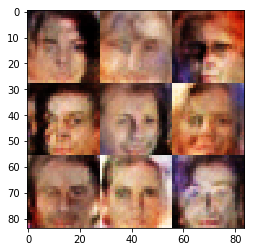

Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7769


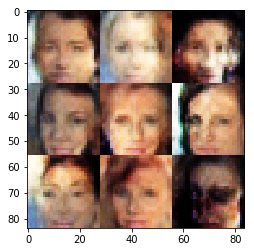

Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.9127


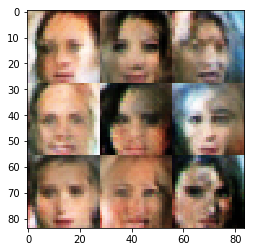

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8243


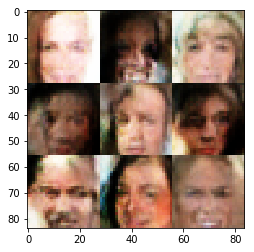

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7372


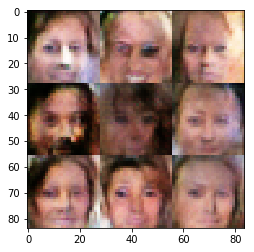

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7096


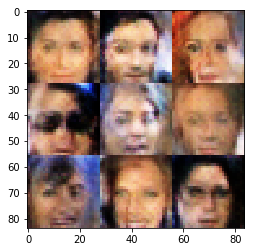

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8894


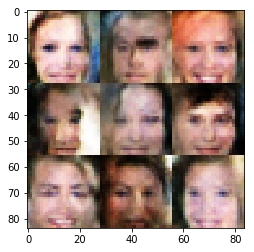

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.9402


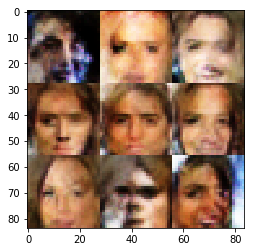

Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7527


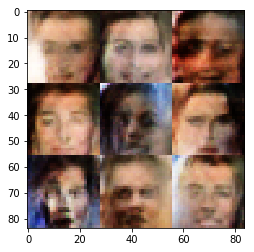

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8018


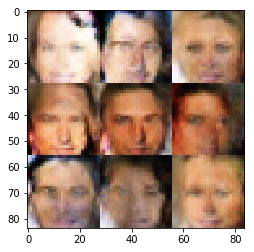

Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.8955


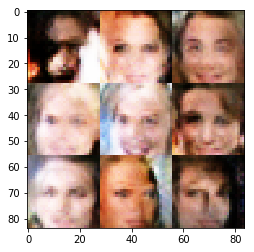

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7880


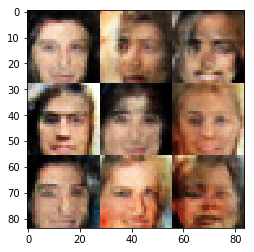

Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8548


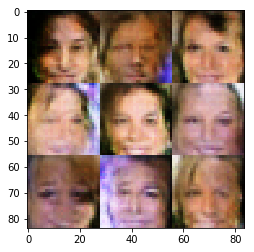

Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.8154


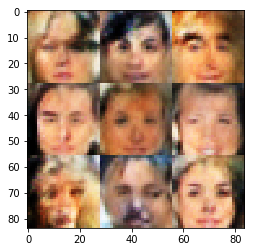

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8432


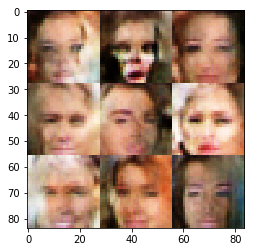

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8799


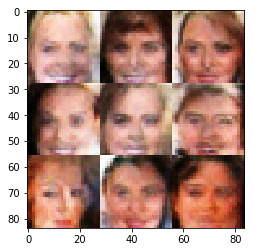

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7990


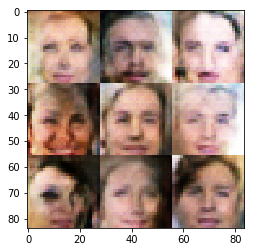

Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8060


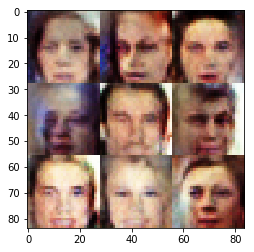

Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7989


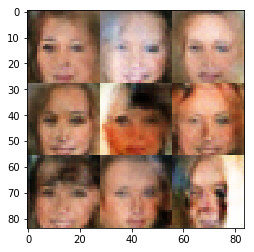

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8707


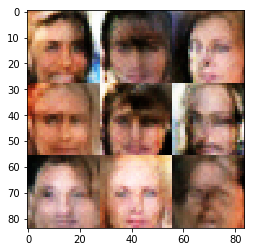

Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7843


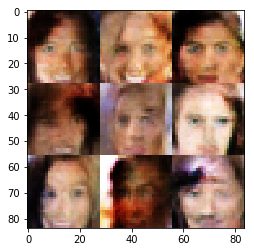

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8488


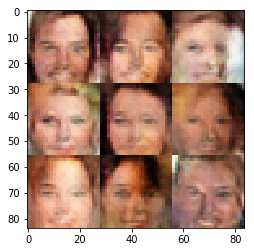

Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7505


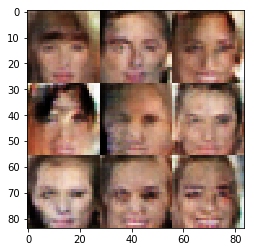

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7928


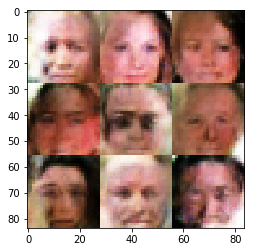

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7576


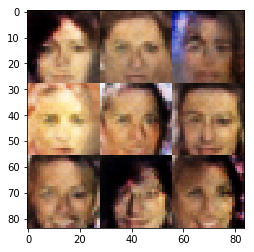

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7364


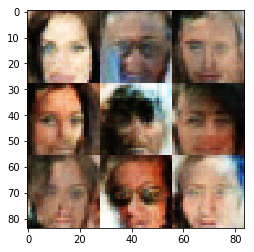

Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8015


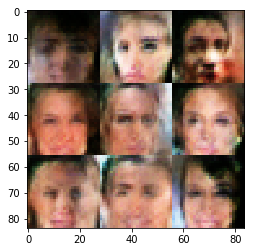

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8061


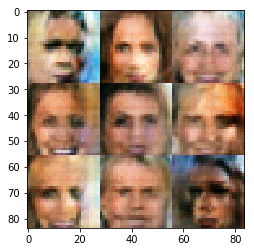

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7575


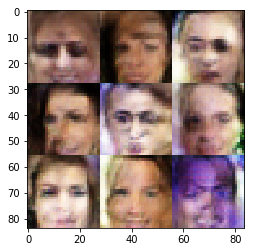

Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7547


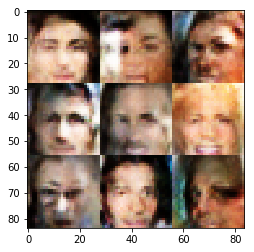

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7659


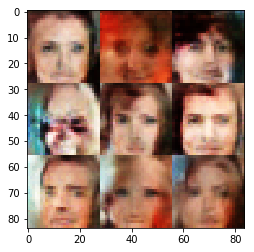

Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7673


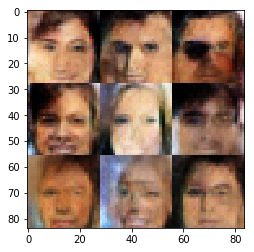

Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7729


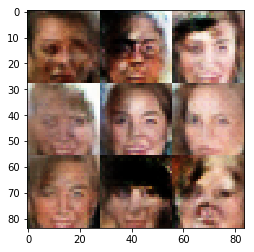

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8566


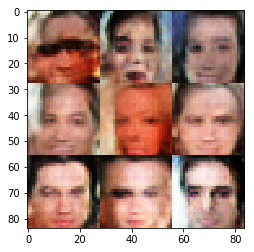

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.8516


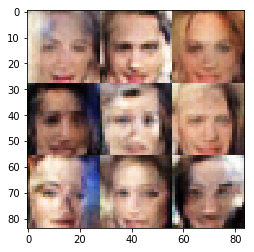

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7848


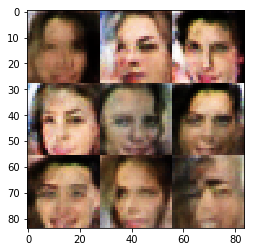

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7806


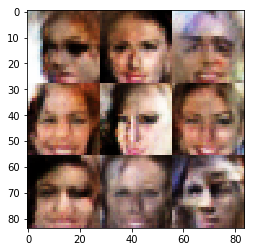

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7402


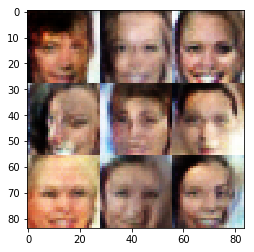

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8061


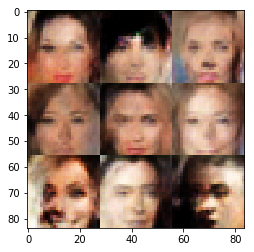

Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.9253


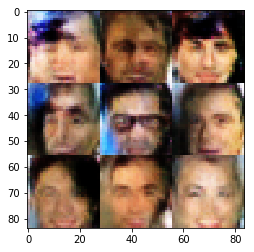

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8022


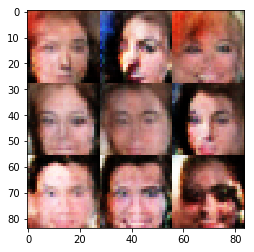

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8415


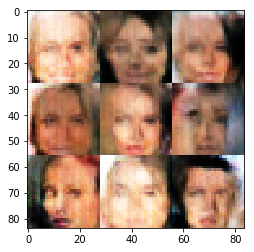

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7889


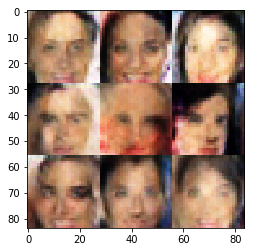

Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7666


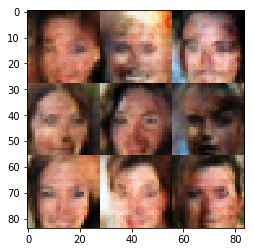

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7985


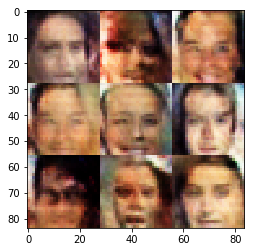

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8318


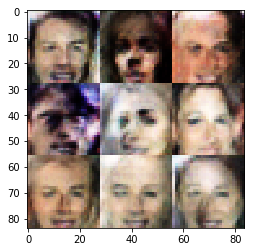

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8235


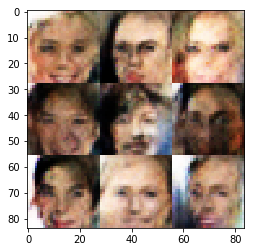

Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.7677


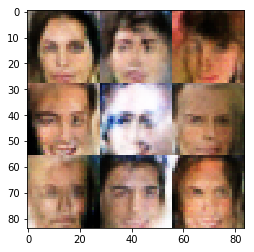

In [ ]:
batch_size = 10
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。